In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, Guide, GroupedBatchSampler

# Read data

In [2]:
s_pymnt = pd.read_json('training.jsonl.gz', lines=True).set_index('id').pymnt

In [3]:
df = pd.read_csv('training.csv.gz', index_col='id')
df = df.join(s_pymnt, how='inner').reset_index()

In [4]:
df.pymnt = df.pymnt.apply(torch.tensor)

# Read model

In [5]:
device = 'cuda:0'

In [6]:
import pyro
pyro.get_param_store().load('param_store.pt')

/home/daniel/miniconda3/envs/pytorch/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(input_file

In [7]:
model = Model(embedding_size=4, device=device)
model.load_state_dict(torch.load('model_params.pt', weights_only=True))

<All keys matched successfully>

In [8]:
guide = Guide(embedding_size=4, device=device)
guide.load_state_dict(torch.load('guide_params.pt', weights_only=True))

<All keys matched successfully>

# Perform test simulation

In [9]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batch_id=row.batch_id, 
    batch_idx=torch.tensor(row.batch_idx).repeat(100).to(device), 
    installments=torch.tensor(row.installment).repeat(100).to(device),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100).to(device), 
    int_rate=torch.tensor(row.int_rate).repeat(100).to(device), 
    num_timesteps=torch.tensor(row.n_report_d))

id                                                             1276318
batch_idx                                                        16582
batch_id                                                             0
report_d             ['2012-06-01T00:00:00.000', '2012-07-01T00:00:...
loan_amnt                                                        10000
int_rate                                                         12.12
installment                                                     332.72
n_report_d                                                          36
total_pre_chargeoff                                         11860.767407
score                                                         0.000001
score_prior                                                   0.045771
pymnt                [tensor(332.6721), tensor(332.6721), tensor(33...
Name: 16582, dtype: object


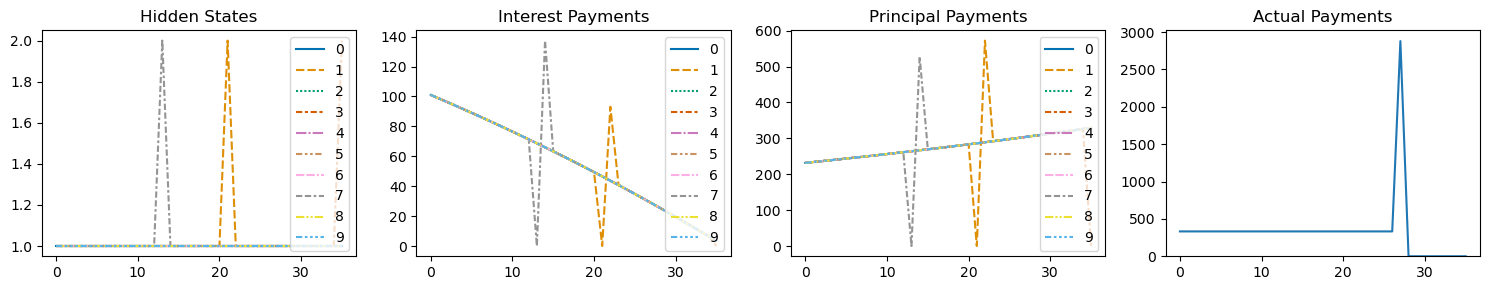

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
sns.lineplot(hidden_states.cpu().detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(interst_payments.cpu().detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(principal_payments.cpu().detach().numpy()[:,:10], ax=ax[2], palette='colorblind')
sns.lineplot(row.pymnt.cpu(), ax=ax[3])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Interest Payments")
ax[2].set_title(f"Principal Payments")
ax[3].set_title(f"Actual Payments")
ax[3].set_ylim(0)
plt.tight_layout()
plt.show()

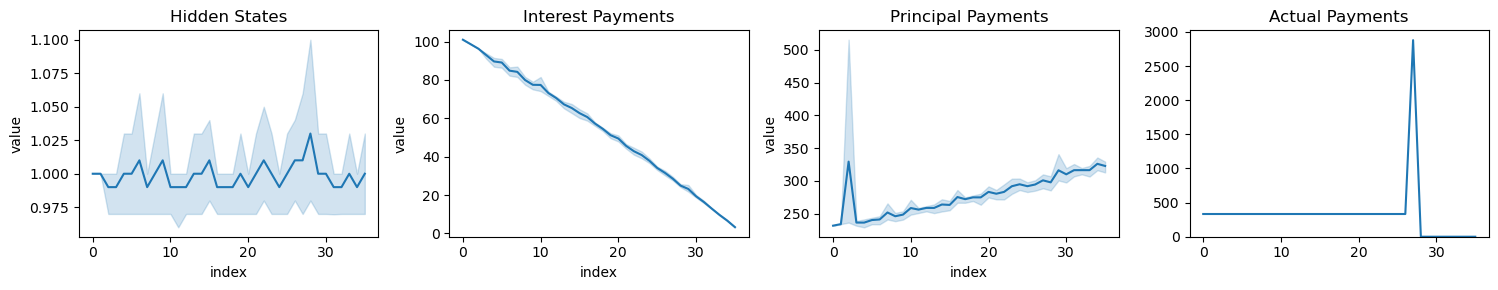

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(interst_payments.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(pd.DataFrame(principal_payments.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[2])
sns.lineplot(row.pymnt.cpu(), ax=ax[3])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Interest Payments")
ax[2].set_title(f"Principal Payments")
ax[3].set_title(f"Actual Payments")
ax[3].set_ylim(0)
plt.tight_layout()
plt.show()

# Simulate full dataset

In [12]:
batch_size = 100_000
dataset = df[['id', 'loan_amnt', 'int_rate', 'installment', 'n_report_d', 'total_pre_chargeoff']].to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [13]:
from torch.utils.data import DataLoader

In [14]:
batches = [] 
for batch_id, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(
            batch_id=batch_id,
            batch_idx=torch.arange(len(batch['id'])).to(device), 
            installments=batch['installment'].to(device), 
            loan_amnt=batch['loan_amnt'].to(device), 
            int_rate=batch['int_rate'].to(device), 
            num_timesteps=batch['n_report_d'].unique().item()))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)

# Score distributions

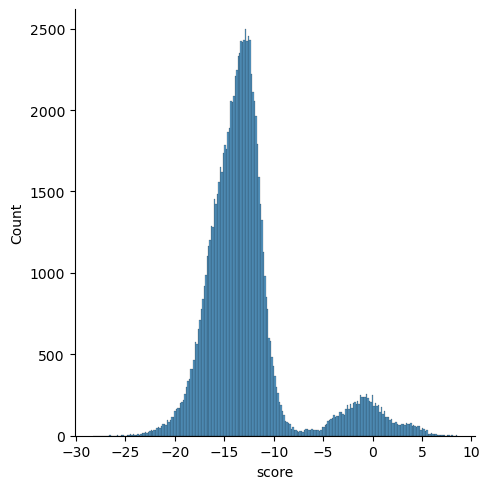

In [15]:
from scipy.special import logit

sns.displot(logit(df.score), kind='hist')

In [16]:
from itertools import chain

s_sim_pymnts = pd.Series(
    torch.concat([x.sum(axis=0) for x in sim_pymnts]).cpu(), 
    index=chain.from_iterable(grouped_batch_sampler.batches)
)

In [17]:
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [18]:
df[['total_pre_chargeoff', 'sim_pymnts_sum']].sum()

total_pre_chargeoff    1.196029e+09
sim_pymnts_sum       1.186609e+09
dtype: float64

<Axes: xlabel='score_qcut'>

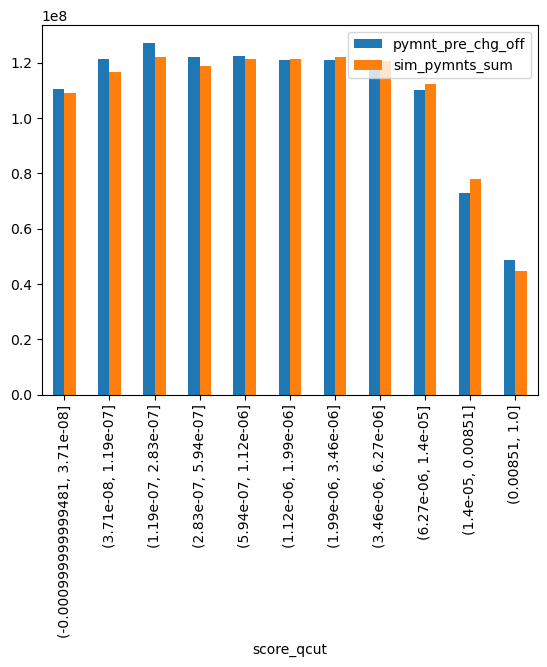

In [19]:
df['score_qcut'] = pd.qcut(df.score, q=11)
df.groupby('score_qcut', observed=False)[['total_pre_chargeoff', 'sim_pymnts_sum']].sum().plot.bar()